In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
!pip install seaborn

In [4]:
!pip install matplotlib

In [5]:
import matplotlib.pyplot as plt

In [6]:
sales = pd.read_csv('sales_data_sample.csv',encoding='latin1')

In [7]:
sales.head(1)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.7,2,2871.0,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small


In [9]:
!pip freeze > requirements.txt


Data Range: 2003-01-06 to 2005-05-31
Total Days: 252
Average Daily Sales: $32,900.34

Model Performance:
MAE: $13,700.25
RMSE: $16,409.48
Mean Actual: $30,711.70
Error %: 44.61%


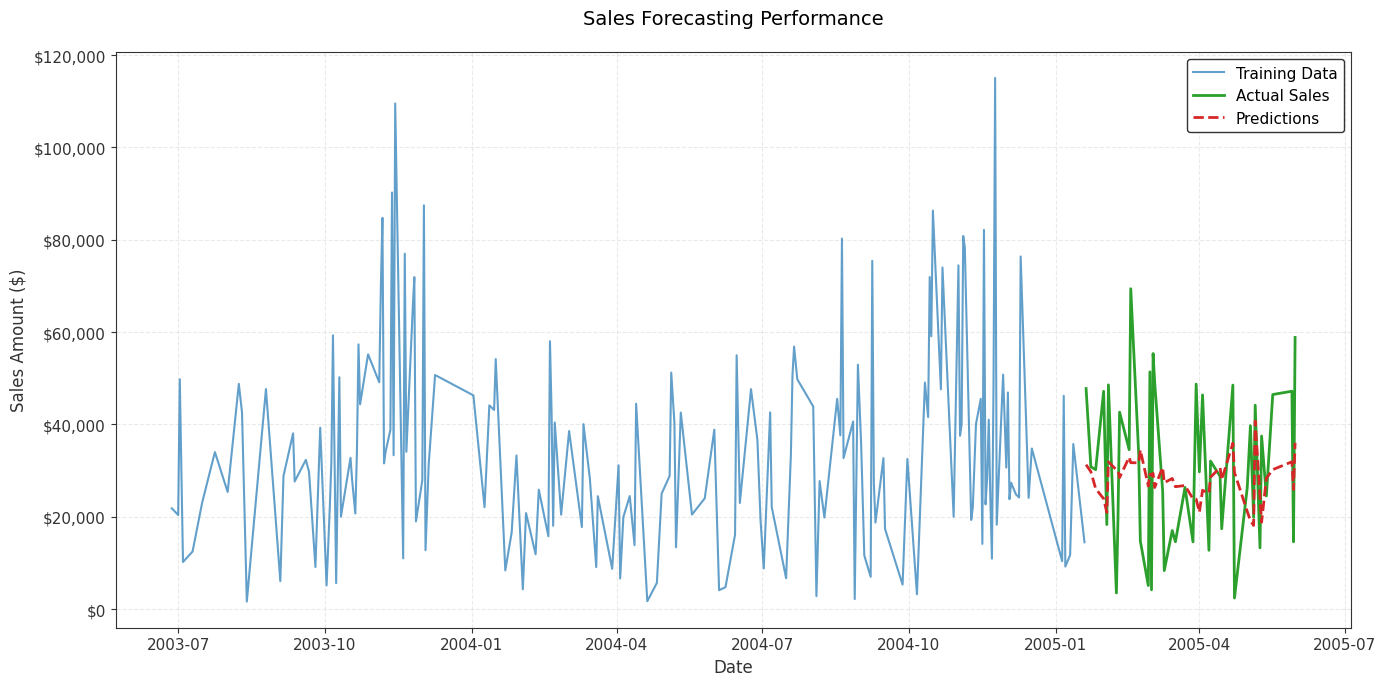

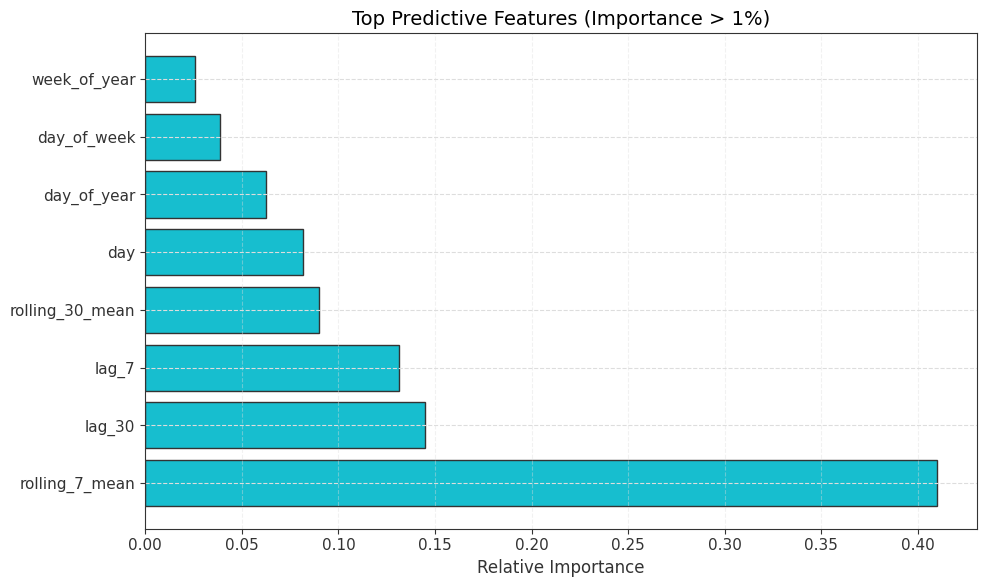

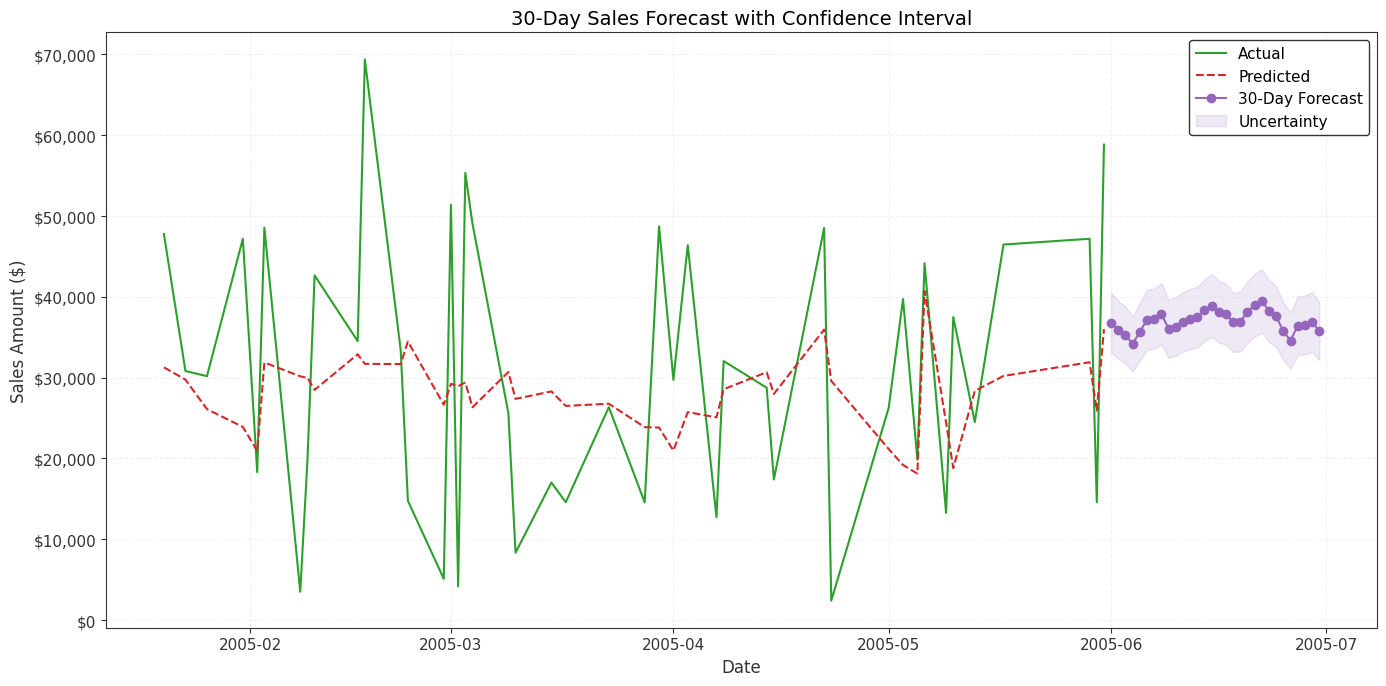

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Set matplotlib style parameters directly
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.color': '#dddddd',
    'grid.linestyle': '--',
    'axes.edgecolor': '#333333',
    'axes.labelcolor': '#333333',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.color': '#333333',
    'ytick.color': '#333333',
    'font.size': 11
})

# 1. Load and prepare data with error handling
try:
    df = pd.read_csv('sales_data_sample.csv', encoding='latin1')
    
    # Verify required columns exist
    required_columns = ['ORDERDATE', 'QUANTITYORDERED', 'PRICEEACH']
    if not all(col in df.columns for col in required_columns):
        missing = [col for col in required_columns if col not in df.columns]
        raise ValueError(f"Missing required columns: {missing}")
    
    # Convert and calculate
    df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
    df['SALES'] = df['QUANTITYORDERED'] * df['PRICEEACH']
    
except Exception as e:
    print(f"Error loading data: {str(e)}")
    exit()

# 2. Data aggregation with checks
daily_sales = df.groupby('ORDERDATE')['SALES'].sum().reset_index()
if len(daily_sales) == 0:
    raise ValueError("No sales data found after aggregation")

print(f"\nData Range: {daily_sales['ORDERDATE'].min().date()} to {daily_sales['ORDERDATE'].max().date()}")
print(f"Total Days: {len(daily_sales)}")
print(f"Average Daily Sales: ${daily_sales['SALES'].mean():,.2f}")

# 3. Enhanced Feature Engineering
def create_features(df, target_col='SALES'):
    """Safe feature engineering with checks"""
    df = df.copy()
    
    # Date features
    date_feats = {
        'day': df['ORDERDATE'].dt.day,
        'month': df['ORDERDATE'].dt.month,
        'year': df['ORDERDATE'].dt.year,
        'day_of_week': df['ORDERDATE'].dt.dayofweek,
        'day_of_year': df['ORDERDATE'].dt.dayofyear,
        'week_of_year': df['ORDERDATE'].dt.isocalendar().week
    }
    
    for name, val in date_feats.items():
        df[name] = val
    
    # Only calculate lags/rolling if target exists
    if target_col in df.columns:
        lags = [7, 30]
        for lag in lags:
            df[f'lag_{lag}'] = df[target_col].shift(lag)
        
        windows = [7, 30]
        for window in windows:
            df[f'rolling_{window}_mean'] = df[target_col].rolling(window).mean()
    
    return df

feature_df = create_features(daily_sales).dropna()
if len(feature_df) == 0:
    raise ValueError("No data left after feature engineering")

# 4. Train-Test Split with validation
test_size = int(len(feature_df) * 0.2)
if test_size == 0:
    test_size = 1  # Ensure at least one test sample

X = feature_df.drop(['ORDERDATE', 'SALES'], axis=1)
y = feature_df['SALES']
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# 5. Scaling with checks
scaler = StandardScaler()
try:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
except ValueError as e:
    print(f"Scaling error: {str(e)}")
    exit()

# 6. Modeling with enhanced parameters
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    n_jobs=-1  # Use all CPU cores
)

model.fit(X_train_scaled, y_train)

# 7. Enhanced Evaluation
predictions = model.predict(X_test_scaled)
metrics = {
    'MAE': mean_absolute_error(y_test, predictions),
    'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
    'Mean Actual': y_test.mean(),
    'Error %': mean_absolute_error(y_test, predictions) / y_test.mean() * 100
}

print("\nModel Performance:")
for k, v in metrics.items():
    if k == 'Error %':
        print(f"{k}: {v:.2f}%")
    else:
        print(f"{k}: ${v:,.2f}")

# 8. Improved Visualizations using pure matplotlib
fig, ax = plt.subplots(figsize=(14, 7))

# Plot training, test, and predictions
ax.plot(feature_df['ORDERDATE'][:-test_size], y_train, 
        label='Training Data', color='#1f77b4', alpha=0.7, linewidth=1.5)
ax.plot(feature_df['ORDERDATE'][-test_size:], y_test, 
        label='Actual Sales', color='#2ca02c', linewidth=2)
ax.plot(feature_df['ORDERDATE'][-test_size:], predictions, 
        label='Predictions', color='#d62728', linestyle='--', linewidth=2)

ax.set_title('Sales Forecasting Performance', pad=20)
ax.set_xlabel('Date')
ax.set_ylabel('Sales Amount ($)')
ax.legend(framealpha=1, edgecolor='#333333')
ax.grid(True, linestyle='--', alpha=0.6)

# Format y-axis as currency
ax.yaxis.set_major_formatter('${x:,.0f}')

plt.tight_layout()
plt.show()

# Feature Importance with thresholds
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Filter insignificant features
importance = importance[importance['Importance'] > 0.01]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance['Feature'], importance['Importance'], 
        color='#17becf', edgecolor='#333333')
ax.set_title('Top Predictive Features (Importance > 1%)')
ax.set_xlabel('Relative Importance')
ax.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 9. Robust Future Forecasting
last_date = feature_df['ORDERDATE'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Create future dataframe safely
future_df = pd.DataFrame({'ORDERDATE': future_dates})
future_df['SALES'] = np.nan  # Dummy column
future_features = create_features(future_df)

# Fill lags/rolling with last known values
for col in ['lag_7', 'lag_30', 'rolling_7_mean', 'rolling_30_mean']:
    if col in feature_df.columns:
        future_features[col] = feature_df[col].iloc[-1]
    else:
        future_features[col] = 0  # Default if feature missing

# Predict and plot
future_X = future_features[X.columns]  # Ensure same columns as training
future_X_scaled = scaler.transform(future_X)
future_predictions = model.predict(future_X_scaled)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(feature_df['ORDERDATE'][-test_size:], y_test, 
        label='Actual', color='#2ca02c')
ax.plot(feature_df['ORDERDATE'][-test_size:], predictions, 
        label='Predicted', linestyle='--', color='#d62728')
ax.plot(future_dates, future_predictions, 
        label='30-Day Forecast', color='#9467bd', marker='o', markersize=6)

# Confidence interval
ax.fill_between(future_dates, 
                future_predictions * 0.9,  # 10% lower bound
                future_predictions * 1.1,  # 10% upper bound
                color='#9467bd', alpha=0.15, label='Uncertainty')

ax.set_title('30-Day Sales Forecast with Confidence Interval')
ax.set_xlabel('Date')
ax.set_ylabel('Sales Amount ($)')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.legend(framealpha=1, edgecolor='#333333')
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()